# <a name="0">Machine Learning Accelerator - Computer Vision - Lecture 1</a>

## Neural Networks with PyTorch

In this notebook, we build, train and validate a Neural Network in [PyTorch](https://pytorch.org/docs/stable/index.html), an open source machine learning framework that accelerates the path from research prototyping to production deployment with a clear, concise, and simple API. 

1. <a href="#1">Implementing a neural network with PyTorch</a>       
2. <a href="#2">Loss Functions</a>
3. <a href="#3">Training</a>
4. <a href="#4">Example - Binary Classification</a>

In [1]:
! pip install -q nvidia-ml-py3==7.352.0
! pip install -q torch==1.10.1
! pip install -q torchvision==0.11.2
! pip install -q d2l==0.16.0
! pip install -q numpy==1.19.5

## 1. <a name="1">Implementing a neural network with PyTorch</a>
(<a href="#0">Go to top</a>)

Let's implement a simple neural network with two hidden layers of size 64 using the sequential container (Adding things in sequence). We will have 3 inputs, 2 hidden layers and 1 output layer.

In [2]:
import torch
from torch import nn

net = nn.Sequential(
        nn.Linear(3, 64),     # Linear layer-1 with 64 out_features and input size 3
        nn.Tanh(),            # Tanh activation is applied
        nn.Linear(64, 64),    # Linear layer-2 with 64 units and input size 64  
        nn.Tanh(),            # Tanh activation is applied
        nn.Linear(64, 1))     # Output layer with single unit

print(net)

Sequential(
  (0): Linear(in_features=3, out_features=64, bias=True)
  (1): Tanh()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): Tanh()
  (4): Linear(in_features=64, out_features=1, bias=True)
)


The weight parameters of the `Linear` layer in pytorch are initialized with a modified form of the Xavier Initialization. Using these weights as a start, we can later apply optimization such as SGD to train the weights. As a result, using a strategic technique to initialize the weights is crucial. 

Here is a full list of [Initializers](https://pytorch.org/docs/stable/nn.init.html). The commonly used one is called *Xavier initilaization*, which can keep the scale of gradients roughly the same in all the layers. (Here are more technical details of [Xavier initilaization](https://d2l.ai/chapter_multilayer-perceptrons/numerical-stability-and-init.html#xavier-initialization).)

We can easily access them with `net[layer_index]`:

In [3]:
print(net[0])
print(net[1])
print(net[2])
print(net[3])
print(net[4])

Linear(in_features=3, out_features=64, bias=True)
Tanh()
Linear(in_features=64, out_features=64, bias=True)
Tanh()
Linear(in_features=64, out_features=1, bias=True)


## 2. <a name="2">Loss Functions</a>
(<a href="#0">Go to top</a>)

We can select [loss functions](https://d2l.ai/chapter_linear-networks/linear-regression.html#loss-function) according to our problem. A full list of supported `Loss` functions in PyTorch are available [here](https://pytorch.org/docs/stable/nn.html#loss-functions). 

Let's go over some popular loss functions and see how to call a built-in loss function:


__Binary Cross-entropy Loss:__ A common used loss function for binary classification. 

```python
loss = nn.BCELoss()
```

__Categorical Cross-entropy Loss:__ A common used loss function for multi-class classification. 

```python
loss = nn.CrossEntropyLoss()
```

__MSE Loss:__ One of the most common loss functions for regression problems. 

```python
loss = nn.MSELoss()
```

## 3. <a name="3">Training</a>
(<a href="#0">Go to top</a>)

`torch.optim` module provides necessary optimization algorithms for neural networks. We can use the following `Optimizers` to train a network using [Stochastic Gradient Descent (SGD)](https://d2l.ai/chapter_optimization/sgd.html) method and learning rate of 0.001.

```python
from torch import optim
optimizer = optim.SGD(net.parameters(), lr=0.001)
```

## 4. <a name="4">Example - Binary Classification</a>
(<a href="#0">Go to top</a>)

In this example, we will train a neural network on a dataset that we randomly generated. We will have two classes and train a neural network to classify them.

In [4]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=750, shuffle=True, random_state=42, noise=0.05, factor=0.3)

First let's plot the simulated dataset.

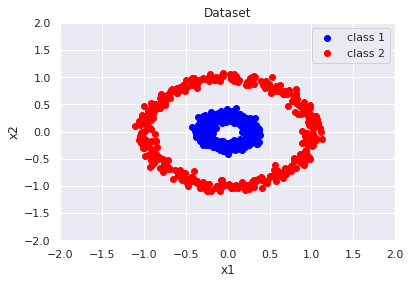

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

def plot_dataset(X, y, title):
    
    # Activate Seaborn visualization
    sns.set()
    
    # Plot both classes: Class1->Blue, Class2->Red
    plt.scatter(X[y==1, 0], X[y==1, 1], c='blue', label="class 1")
    plt.scatter(X[y==0, 0], X[y==0, 1], c='red', label="class 2")
    plt.legend(loc='upper right')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.title(title)
    plt.show()
    
plot_dataset(X, y, title="Dataset")

Next, we import the necessary libraries and classes.

In [6]:
import time
from torch.nn import BCELoss

Then, we create the network as below. It will have two hidden layers. Since the data seems easily seperable, we can have a small network (2 hidden layers) with 10 units at each layer.

In [7]:
# Use GPU resource if available, otherwise wil use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = nn.Sequential(nn.Linear(in_features=2, out_features=10),
                    nn.ReLU(),
                    nn.Linear(10, 10),
                    nn.ReLU(),
                    nn.Linear(10, 1),
                    nn.Sigmoid()).to(device)

Now let's prepare the training set and validation set, and load each of them to a `DataLoader`, respectively.

In [8]:
# Split the dataset into two parts: 80%-20% split
X_train, X_val = X[0:int(len(X)*0.8), :], X[int(len(X)*0.8):, :]
y_train, y_val = y[:int(len(X)*0.8)], y[int(len(X)*0.8):]

# Use PyTorch DataLoaders to load the data in batches
batch_size = 4           # How many samples to use for each weight update 
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                               torch.tensor(y_train, dtype=torch.float32))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)

# Move validation dataset on CPU/GPU device
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)

Before the training, one last thing is to define the hyper-parameters for training.

In [9]:
epochs = 50   # Total number of iterations
lr = 0.01     # Learning rate

# Define the loss. As we used sigmoid in the last layer, we use `nn.BCELoss`.
# Otherwise we could have made use of `nn.BCEWithLogitsLoss`.
loss = BCELoss(reduction='none')

# Define the optimizer, SGD with learning rate
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

Finally, it is the time for training! We will run through the training set 50 times (i.e., epochs) and print training and validation losses at each epoch.

In [10]:
train_losses = []
val_losses = []
for epoch in range(epochs):
    start = time.time()
    training_loss = 0
    # Build a training loop, to train the network
    for idx, (data, target) in enumerate(train_loader):
        # zero the parameter gradients
        optimizer.zero_grad()
        # Put data and label to the correct device
        data = data.to(device)
        # view(-1, 1) reshapes (batch_size, ) to (batch_size, 1)
        target = target.to(device).view(-1, 1) 
        # Make forward pass
        output = net(data)
        # Calculate loss
        L = loss(output, target).sum()
        training_loss += L.item()
        # Make backwards pass (calculate gradients)
        L.backward()
        # Update weights
        optimizer.step()
    
    # Get validation predictions
    val_predictions = net(X_val)
    # Calculate the validation loss
    val_loss = torch.sum(loss(val_predictions, y_val.view(-1, 1))).item()
    
    # Take the average losses
    training_loss = training_loss / len(y_train)
    val_loss = val_loss / len(y_val)
    
    train_losses.append(training_loss)
    val_losses.append(val_loss)
    
    end = time.time()
    # Print the losses every 10 epochs
    if (epoch == 0) or ((epoch+1)%10 == 0):
        print("Epoch %s. Train_loss %f Validation_loss %f Seconds %f" % \
              (epoch, training_loss, val_loss, end-start))

Epoch 0. Train_loss 0.690807 Validation_loss 0.682380 Seconds 0.239305
Epoch 9. Train_loss 0.015132 Validation_loss 0.014064 Seconds 0.208627
Epoch 19. Train_loss 0.003263 Validation_loss 0.003611 Seconds 0.236998
Epoch 29. Train_loss 0.001654 Validation_loss 0.001957 Seconds 0.164836
Epoch 39. Train_loss 0.001071 Validation_loss 0.001326 Seconds 0.238326
Epoch 49. Train_loss 0.000779 Validation_loss 0.000997 Seconds 0.150228


Let's see the training and validation loss plots below. Losses go down as the training process continues as expected.

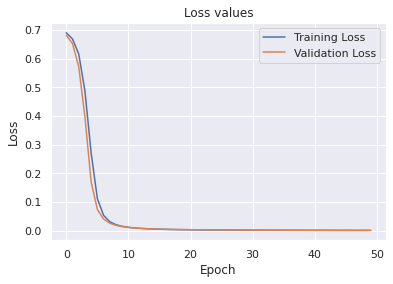

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss values")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()